In [1]:
import torch
from PIL import Image
import torchvision
import numpy as np
from detection_transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotate, RandomResize, Compose, ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn
from data import BedsoreDataset,BedsoreDataModule
from utils import batch2pil

### 暂时保留可能有用

In [2]:
net = maskrcnn_resnet50_fpn(pretrained=True)
in_features = net.roi_heads.box_predictor.cls_score.in_features
net.roi_heads.box_predictor = FastRCNNPredictor(in_features, 7)

In [3]:
tfmc_train = Compose([ToTensor()])
ds = BedsoreDataset('data', transforms=tfmc_train)
image,target = ds[4]

In [4]:
target

{'boxes': tensor([[ 28.2734, 129.2988, 371.7831, 320.7009],
         [227.0000, 197.0000, 288.0000, 245.0000],
         [ 70.0000, 187.0000, 163.0000, 265.0000],
         [189.0000, 220.0000, 229.0000, 258.0000]]),
 'labels': tensor([5, 8, 7, 7]),
 'image_id': tensor([4]),
 'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0.,

In [3]:
%debug

> /home/zrway/Projects/Bedsore/data.py(70)__getitem__()
     68 
     69         masks = torchvision.transforms.ToTensor()(masks)
---> 70         masks = torch.cat((pre_masks,masks),dim=0)
     71         target['masks'] = masks
     72         import ipdb; ipdb.set_trace()



ipdb>  pre_masks.shape


torch.Size([1, 424, 414])


ipdb>  masks.shape


torch.Size([414, 3, 424])


ipdb>  masks.shape


torch.Size([414, 3, 424])


ipdb>  q


In [17]:
net([image],[target])

/home/zrway/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


{'loss_classifier': tensor(2.0093, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.0623, grad_fn=<DivBackward0>),
 'loss_mask': tensor(0.4225, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_objectness': tensor(0.0339, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0044, grad_fn=<DivBackward0>)}

In [9]:
dm = BedsoreDataModule('data', 1)
dm.setup()

In [10]:
test_x  = next(iter(dm.val_dataloader()))[0]

In [1]:
from model import MyFasterRCNN

In [2]:
model = MyFasterRCNN.load_from_checkpoint('mlruns/0/a3c2e29391714b9a8fa06defdba070f7/checkpoints/epoch=17.ckpt')

In [6]:
net = model.net
net.eval()
pass

In [12]:
out = net(test_x)

/home/zrway/anaconda3/lib/python3.7/site-packages/torchvision/ops/poolers.py:216: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_in_level = torch.nonzero(levels == level).squeeze(1)


In [48]:
mask = out[0]['masks'][0]

In [ ]:
torchvision.transforms.ToPILImage()((mask>0).float())

In [60]:
out[0]['masks'].max()

tensor(0.1052, grad_fn=<MaxBackward1>)

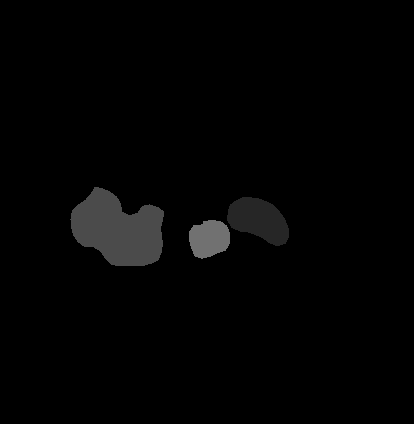

In [14]:
mask = Image.open('data/VOCdevkit/VOC2007/SegmentationObject/B01_00007.png').convert('L')
mask

In [19]:
mask = np.array(mask)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [21]:
obj_ids = np.unique(mask)[1:]
obj_ids

array([ 38,  75, 113], dtype=uint8)

In [22]:
masks = mask == obj_ids[:, None, None]

In [62]:
mask_cls = Image.open('data/VOCdevkit/VOC2007/SegmentationClass/B01_00007.png').convert('L')
mask_cls = np.array(mask_cls)
obj_ids = np.unique(mask_cls)[1:]
obj_ids

array([137, 173], dtype=uint8)

In [67]:
mask_clas = masks * mask_cls

In [84]:
mask_clas[0].max()

173

In [97]:
mask_clas.max(1).max(1)

array([173, 137, 137], dtype=uint8)

In [4]:
a = [132,43]

In [5]:
a == 132

False

### Load checkpoint and plot

In [5]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
import os
from PIL import Image
import numpy as np

In [6]:
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1, trans_prob=0.5)
ds = dm.val_dataloader().dataset
model = MyFasterRCNN.load_from_checkpoint('mlruns/0/d943453c13254916a4bc0765d150437f/checkpoints/epoch=21.ckpt')
net = model.net
net.eval()
pass

/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 " "in albumentations 0.5.0", DeprecationWarning


AttributeError: Missing attribute "train_layers"

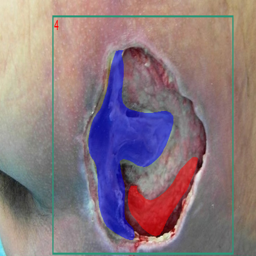

In [11]:
idx = 4
image,target = ds[idx]
# out = net([image],[target])[0]
# print(target['fname'])
# print('gt:',target['labels'])
# print('out labels: ', out['labels'])
# print('out scores: ', out['scores'].detach())

# good_labels = out['labels'][out['scores']>0.5]
# good_masks = out['masks'][out['scores']>0.5][good_labels>6]
# good_labels = good_labels[good_labels>6]
# print('tissue:',good_labels, good_masks.shape)


draw_bbox(image,target).resize((256,256))

In [4]:
%debug

> /home/zrway/Projects/Bedsore/utils.py(75)draw_bbox()
     73     tissue = {7:hs, 8:fr, 9:ry}
     74 
---> 75     if 'scores' in target.keys: # 如果有分数
     76         good_labels = target['labels'][target['scores']>th]
     77         good_masks = target['masks'][target['scores']>th][good_labels>6]



ipdb>  target.keys()


dict_keys(['boxes', 'labels', 'image_id', 'fname', 'masks'])


ipdb>  exit


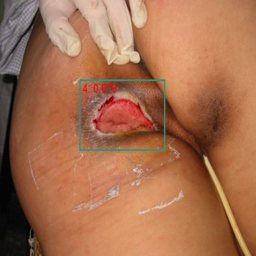

In [9]:
SZ = 256
ry = Image.new("RGB",(SZ,SZ),(255,0,0))
fr = Image.new("RGB",(SZ,SZ),(255,255,0))
hs = Image.new("RGB",(SZ,SZ),(0,0,255))
tissue = {7:hs, 8:fr, 9:ry}
img_out = draw_bbox(image,out).resize((SZ,SZ))


for i,t in enumerate(good_labels):
    mask = batch2pil(((good_masks[i])>0.5).float()).resize((SZ,SZ))
    mask = np.array(mask)*0.5
    mask = Image.fromarray(mask.astype('uint8')).convert('L')
    img_out = Image.composite(tissue[t.item()], img_out, mask)
    
img_out

In [63]:
# draw_bbox(image,out).resize((256,256))
# batch2pil(((good_masks[1])>0.5).float()).resize((256,256))

### Batch Eval 计算分数

In [1]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
from tqdm import tqdm
import voc_eval
import os

detpath = 'temp/det_outs.txt'
imgsetfile = 'temp/evallist.txt'

In [2]:
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1,trans_prob=0.5)
ds = dm.val_dataloader().dataset
model = MyFasterRCNN.load_from_checkpoint('mlruns/0/40eb48da3c844db9afc77346b7d1d29f/checkpoints/epoch=18.ckpt')
net = model.net
net.eval()
pass

/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 " "in albumentations 0.5.0", DeprecationWarning


In [4]:
# 预测
outs = []
for image,target in tqdm(ds):
    out = net([image],[target])[0]
    outs += out2detfile(target,out)        

  0%|          | 0/100 [00:00<?, ?it/s]/home/zrway/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


In [5]:
# 将检测结果写入文件
os.remove(detpath)
for i in outs:
    with open(detpath,'a+') as f:
        f.write(i)

In [5]:
# 预测文件列表

os.remove(imgsetfile)
for _,target in ds:
    fname= target['fname']
    with open(imgsetfile,'a') as f:
        f.write(fname +'\n')

In [ ]:
voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  '深部组织损伤',
                  ovthresh=0.3,
                  use_07_metric=True)

In [8]:
tissus_name = ['1期','2期','3期','4期','不可分期','深部组织损伤']
mAP = []
for i in tissus_name:
    ap = voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  i,
                  ovthresh=0.3,
                  use_07_metric=True)[-1]
    print(i,ap)
    mAP.append(ap)
sum(mAP)/len(mAP)

0.0
0.4418081918081918
0.5099206349206349
0.7665188470066518
0.5867965367965369
0.7272727272727274


0.5053861563007905

### 标签数量探索

In [20]:
from data import BedsoreDataModule, BedsoreDataset
import torch
from tqdm import tqdm

In [21]:
# dm = BedsoreDataModule(root='data', num_valid=0, batch_size=1,trans_prob=0.5)
ds = BedsoreDataset(image_set='val')

In [22]:
labels = []
for image,target in tqdm(ds):
    labels += target['labels'].tolist()

100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


In [23]:
ls = torch.LongTensor(labels)
for i in range(1,7):
    print(i,sum(ls == i),sum(ls==i)/sum(ls<7))


1 tensor(8) tensor(0.0690)
2 tensor(18) tensor(0.1552)
3 tensor(9) tensor(0.0776)
4 tensor(30) tensor(0.2586)
5 tensor(35) tensor(0.3017)
6 tensor(16) tensor(0.1379)


In [19]:
# 1少一点，选10个出来

2575

In [28]:
labels = []
with open('temp/fname_label.txt','a') as f:
    for image,target in tqdm(ds):
        line = target['fname'] + ',' + str(target['labels'].tolist()) + '\n'
        f.write(line)

100%|██████████| 1438/1438 [07:29<00:00,  3.20it/s]


In [35]:
with open('temp/fname_label.txt','r') as f:
    text = f.readlines()

In [2]:
import pandas as pd
import random
df = pd.read_csv('temp/fname_label.txt')

In [4]:
ctg1_list = []
ctgo_list = []
for i in df.itertuples():
    fname = i[1]
    labels = str(i[2])
    if '1' in labels:
        ctg1_list.append(fname)
    else:
        ctgo_list.append(fname)

In [5]:
len(ctgo_list)

1382

In [7]:
random.seed(32)
eval_list1 = random.sample(ctg1_list,8)
eval_list2 = random.sample(ctgo_list,92)
eval_list = eval_list1 + eval_list2
eval_list

['B01_00064',
 'B01_00157',
 'B01_00125',
 'B01_00201',
 'B04_00263',
 'B01_00169',
 'B04_00054',
 'B01_00038',
 'B01_00099',
 'B01_00250',
 'B04_00265',
 'B06_00017',
 'B04_00277',
 'B01_00144',
 'B06_00045',
 'B05_00115',
 'B04_00361',
 'B06_00207',
 'B01_00003',
 'B06_00085',
 'B02_00056',
 'B06_00049',
 'B01_00028',
 'B05_00149',
 'B03_00075',
 'B04_00178',
 'B03_00072',
 'B05_00067',
 'B01_00204',
 'B04_00285',
 'B02_00044',
 'B01_00090',
 'B06_00051',
 'B02_00022',
 'B02_00142',
 'B05_00051',
 'B01_00056',
 'B05_00036',
 'B01_00128',
 'B06_00112',
 'B04_00325',
 'B04_00043',
 'B02_00151',
 'B05_00113',
 'B04_00229',
 'B05_00163',
 'B02_00165',
 'B06_00069',
 'B04_00203',
 'B06_00139',
 'B06_00154',
 'B01_00207',
 'B01_00084',
 'B06_00177',
 'B04_00183',
 'B04_00048',
 'B04_00179',
 'B04_00275',
 'B01_00198',
 'B04_00082',
 'B07_00053',
 'B04_00423',
 'B04_00181',
 'B05_00025',
 'B01_00178',
 'B05_00131',
 'B01_00027',
 'B03_00012',
 'B05_00065',
 'B02_00150',
 'B01_00228',
 'B01_

In [10]:
# 打乱
eval_list = random.sample(eval_list,100)
len(eval_list)

In [16]:
with open('temp/eval_list.txt','a') as f:
    for line in eval_list:
        f.write(line + '\n')

In [30]:
train_df = pd.read_csv('data/VOCdevkit/VOC2007/ImageSets/Main/train_clearning.txt',names=['fname'])
val_df = pd.read_csv('data/VOCdevkit/VOC2007/ImageSets/Main/val.txt',names=['fname'])
val_df

,fname
0,B04_00203
1,B04_00115
2,B06_00241
3,B06_00069
4,B03_00075
...,...
95,B04_00054
96,B07_00053
97,B05_00065
98,B04_00183


In [31]:
train_df=train_df.append(val_df)
train_df=train_df.drop_duplicates(subset=['fname'],keep=False)
train_df

,fname
0,B01_00001
2,B01_00004
3,B01_00006
4,B01_00007
5,B01_00008
...,...
1433,B07_00073
1434,B07_00074
1435,B07_00075
1436,B07_00076


In [32]:
train_df.to_csv('data/VOCdevkit/VOC2007/ImageSets/Main/train.csv',index=None)

### Test

In [5]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
from tqdm import tqdm
import voc_eval
import os
from pytorch_lightning import Trainer

In [6]:
trainer = Trainer()
dm = BedsoreDataModule('data', 1, 50, 0.5, 32)
ckpt_path = './mlruns/0/a791145f68f047d5a6d2220a89e441f5/checkpoints/epoch=17.ckpt'
model = MyFasterRCNN.load_from_checkpoint(ckpt_path)
trainer.test(model, test_dataloaders=dm.test_dataloader())

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/zrway/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 " "in albumentations 0.5.0", DeprecationWarning
/home/zrway/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)


/home/zrway/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


[['1期', 0.1272727272727273], ['2期', 0.6188246097337007], ['3期', 0.23636363636363633], ['4期', 0.7664170307190902], ['不可分期', 0.7162391688008385], ['深部组织损伤', 0.3545125164690382]]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mAP': 0.4699382815598386}
--------------------------------------------------------------------------------



[{'test_mAP': 0.4699382815598386}]

In [24]:
import pandas as pd

In [33]:
train = pd.read_csv('data/VOCdevkit/VOC2007/ImageSets/Main/train.txt',names=['fname'])
test = pd.read_csv('data/VOCdevkit/VOC2007/ImageSets/Main/val.txt',names=['fname'])

In [40]:
set(test['fname'].values) & set(train['fname'].values) 

set()